In [1]:
import pm4py
pm4py.__version__

'1.2.12'

# Performance Analysis

> Which parts of the process have the biggest influence on the total case duration?

## Data loading

Import the log.

In [3]:
import os
import pandas as pd
from pm4py.objects.log.importer.xes import factory as xes_import_factory
from pm4py.objects.petri.importer import factory as pnml_importer

PROJ_ROOT = os.path.abspath(os.path.pardir)
data_path = os.path.join(PROJ_ROOT, 'data', 'log.csv')

assert os.path.exists(data_path)

# load csv
df_log = pd.read_csv(data_path)

# convert timestamp columns to datetime friendly format
df_log['Timestamp'] = pd.to_datetime(df_log['Timestamp'])
df_log['start_timestamp'] = pd.to_datetime(df_log['start_timestamp'])

#import the renamed event log from Q1
event_log = xes_import_factory.apply(PROJ_ROOT+"/data/processed_log.xes")

#import the filtered petri net obtained in Q1
pnml_path = os.path.join(PROJ_ROOT, 'results', 'Q1', 'filtered_petri.pnml')
net, initial_marking, final_marking = pnml_importer.apply(pnml_path)

---

# a)
> Provide and briefly describe results of your performance analysis. Remember to also consider your current results which may give you a good entry point for a deeper analysis.

We start our exploration of the process performance by evaluating the performance of single activities. At first we visualize the activities duration. The results can be found below.

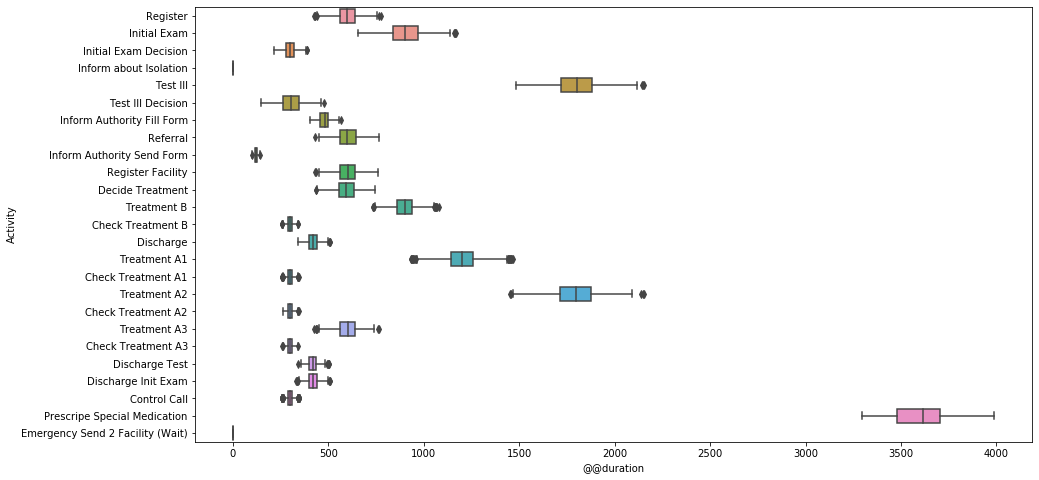

In [65]:
import seaborn as sns

sns.boxplot(data=df_log, y='Activity', x='@@duration', orient='h')
plt.gcf().set_size_inches(15,8)
plt.show()

What we can observe here is that the _Prescripe Special Medication_ activity has by far the largest average duration. In general we see that the activities that are relatd to treatments have the longest duration. 

Administrative tasks like registration activities also show a long duration, while examination decisions and treatment checks have the shortest duration.

All of the standard deviations are small considering the overall duration of the activities, this means that there is not much variation in the time that is required for a specific activity in between cases. We also notice that there is no presence of anomalies in the distributions, all of them seem very close to a normal distribution.

In [74]:
from pm4py.visualization.petrinet import factory as pn_visualizer
from pm4py.algo.discovery.inductive import factory as inductive_miner

#annotate the mined petri net with performance measures
perf_net_vis = pn_visualizer.apply(net, initial_marking, final_marking=final_marking,
                                   variant=pn_visualizer.PERFORMANCE_DECORATION, log=event_log,
                                   parameters=param_keys)

figures_dir = os.path.join(PROJ_ROOT, 'report', 'figures')

# fix place size
import numpy as np
body = np.array(perf_net_vis.body)
body[body ==  '\tnode [fixedsize=true shape=circle width=0.75]'] = '\tnode [fixedsize=true shape=circle width=1]'
perf_net_vis.body = body

perf_net_vis.render(os.path.join(figures_dir, 'q3_perf_petrinet'),
                 format='pdf',
                 view=True)

'/Users/Tom/Documents/Uni/4. Semester M/Advanced Process Mining/Assignments/Assignment 1/APM-A1/report/figures/q3_perf_petrinet.pdf'

We have annotated the petri net that was obtained in Q1 after preprocessing the log with a performance metric. The metric used is the mean time between two events.

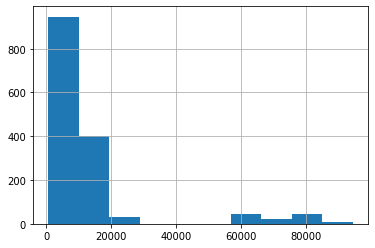

In [66]:
total_process_duration = df_log.groupby('Patient')['@@duration'].sum()

total_process_duration.hist()

We notice roughly two groups here, separated by the 40000 seconds duration mark.

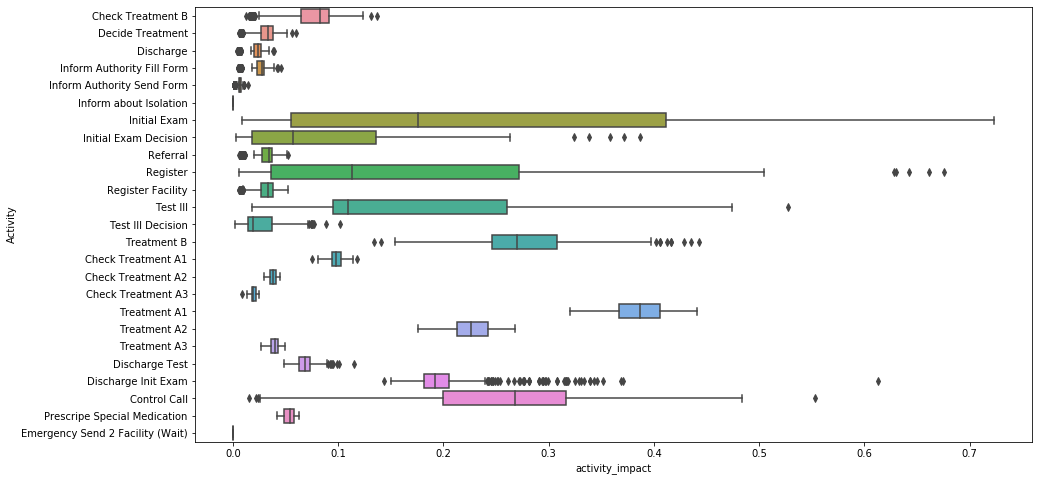

In [67]:
df_activities_impact = df_log.groupby(['Patient', 'Activity'])['@@duration'].sum().reset_index()
df_activities_impact['process_duration'] = df_activities_impact['Patient'].map(total_process_duration)
df_activities_impact['activity_impact'] = df_activities_impact['@@duration'] / df_activities_impact['process_duration']

sns.boxplot(data=df_activities_impact, y='Activity', x='activity_impact', orient='h')
plt.gcf().set_size_inches(15,8)
plt.show()

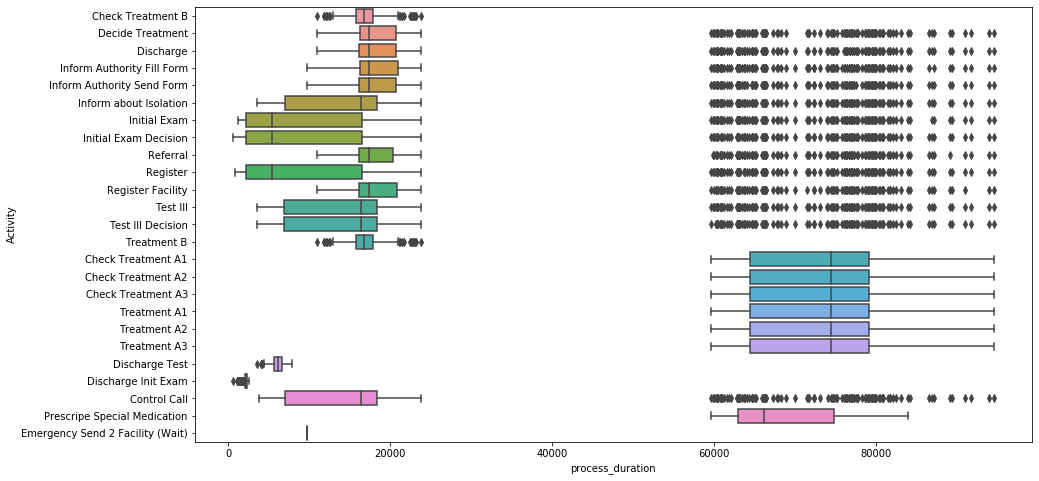

In [68]:
sns.boxplot(data=df_activities_impact, y='Activity', x='process_duration')
plt.gcf().set_size_inches(15,8)
plt.show()

We see that the Treatments A1, A2 and A3 imply in much longer processes.

In [90]:
df_log

,Patient,Activity,Resource,PatientName,Age,Insurance,start_timestamp,Timestamp,@@duration
0,1,Register,Alexander,Hermann the 1.,51,STAT,2020-06-01 06:00:00,2020-06-01 06:08:53,533.0
1,1,Initial Exam,Anna,Hermann the 1.,51,STAT,2020-06-01 06:10:48,2020-06-01 06:25:43,895.0
2,1,Initial Exam Decision,"Amelie,Anna",Hermann the 1.,51,STAT,2020-06-01 06:26:43,2020-06-01 06:31:52,309.0
3,1,Inform about Isolation,Alexander,Hermann the 1.,51,STAT,2020-06-01 06:33:45,2020-06-01 06:33:45,0.0
4,1,Test III,Anna,Hermann the 1.,51,STAT,2020-06-01 06:35:35,2020-06-01 07:03:47,1692.0
...,...,...,...,...,...,...,...,...,...
33859,1500,Control Call,InspectorInis,Ulrich the 1500.,51,PRIV,2020-07-14 07:35:39,2020-07-14 07:40:58,319.0
33860,1500,Control Call,InspectorInis,Ulrich the 1500.,51,PRIV,2020-07-14 11:05:01,2020-07-14 11:09:47,286.0
33861,1500,Test III,Amalia,Ulrich the 1500.,51,PRIV,2020-07-14 13:41:46,2020-07-14 14:13:27,1901.0
33862,1500,Test III Decision,"Amelie,Amalia",Ulrich the 1500.,51,PRIV,2020-07-14 14:13:27,2020-07-14 14:19:18,351.0


Now let's take a look at the lead time of the processes.

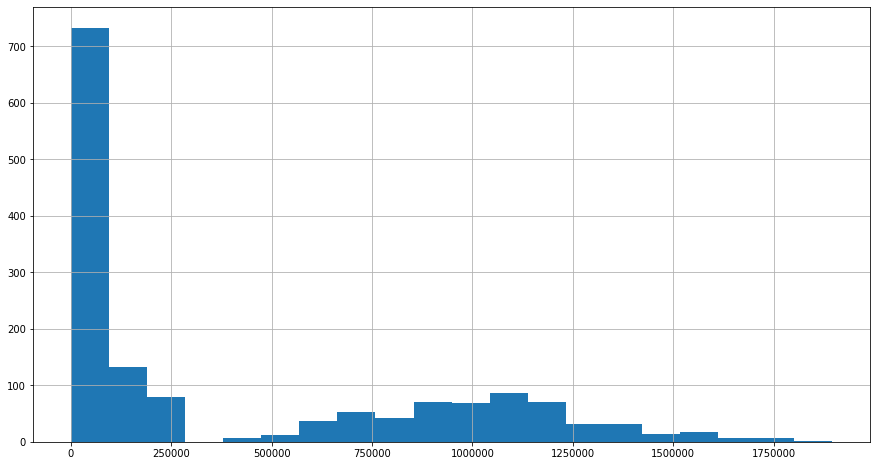

In [222]:
lead_time = df_log.groupby('Patient')['Timestamp'].max() - \
            df_log.groupby('Patient')['Timestamp'].min()

lead_time.apply(lambda t: t.total_seconds()).hist(bins=20)
plt.gcf().set_size_inches(15,8)
plt.show()

Again we see that the lead time has two groupings, split around 370000 seconds.

In [225]:
from pm4py.objects.log.util import get_log_representation, get_class_representation

data, feature_names = get_log_representation.get_representation(
    log=event_log,
    str_tr_attr=['Insurance'],
    str_ev_attr=['Activity'],
    num_tr_attr=[],
    num_ev_attr=['Age']
)
target, classes = get_class_representation.get_class_representation_by_trace_duration(event_log, target_trace_duration=370000, timestamp_key='Timestamp')

from sklearn.tree import DecisionTreeClassifier

# limit DT depth to get a simpler representation, with the main approaches
clf = DecisionTreeClassifier(min_samples_leaf=5)
# clf = DecisionTreeClassifier(min_samples_leaf=15)
clf = clf.fit(data, target)

from pm4py.visualization.decisiontree import factory as dt_visualizer

dt_vis = dt_visualizer.apply(clf, feature_names, classes)

figures_dir = os.path.join(PROJ_ROOT, 'report', 'figures')
dt_vis.render(os.path.join(figures_dir, 'q3_decision_tree'),
              format='pdf',
              view=True)

'/home/bruno/Desktop/APM-A1/report/figures/q3_decision_tree.pdf'

We can see that the major cause for the long lead time of the processes is the happening of `Inform Authority Send Form`, which means that the patient will be forwarded to treatment, therefore taking longer time under observation.

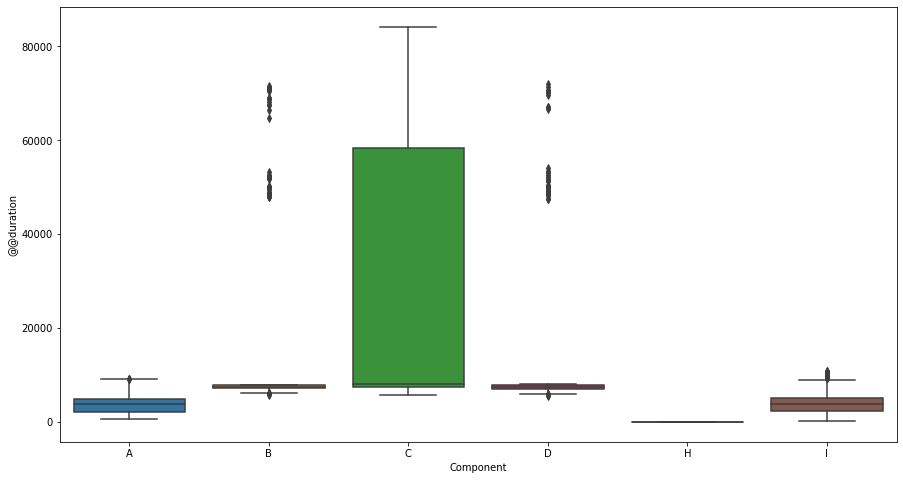

In [242]:
df_log['Component'] = df_log['Resource'].str[0]

df_components = df_log.groupby(['Component', 'Patient'])['@@duration'].sum().reset_index()

sns.boxplot(data=df_components, x='Component', y='@@duration')
plt.gcf().set_size_inches(15,8)
plt.show()

We see that the component C (discussed in Q2) is presenting longer processes duration for the activities than their counterparts B and D, which perform similar activities.

In [245]:
lead_time

Patient
1       5 days 04:56:02
2      11 days 03:06:45
3       5 days 05:10:08
4       0 days 01:59:17
5       5 days 06:01:21
             ...       
1496    2 days 02:40:47
1497   12 days 05:48:34
1498   13 days 08:43:30
1499    0 days 00:47:03
1500    2 days 02:54:39
Name: Timestamp, Length: 1500, dtype: timedelta64[ns]

In [246]:
df_log.groupby('Component')['Patient'].unique()

Component
A    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
B    [1, 2, 3, 5, 8, 13, 21, 24, 33, 38, 41, 43, 49...
C    [26, 46, 58, 73, 81, 85, 93, 100, 114, 116, 11...
D    [14, 31, 35, 37, 48, 52, 57, 63, 77, 79, 80, 8...
H                                               [1276]
I    [23, 24, 25, 26, 31, 33, 34, 35, 37, 38, 40, 4...
Name: Patient, dtype: object

In [232]:
total_process_duration

Patient
1       12181.0
2       73962.0
3       12625.0
4        4521.0
5       11862.0
         ...   
1496     6204.0
1497    22410.0
1498    23034.0
1499     2183.0
1500     6798.0
Name: @@duration, Length: 1500, dtype: float64

In [72]:
#from pm4py.algo.filtering.log.cases import case_filter

#filtered_log = case_filter.filter_on_case_performance(event_log, 86400, 864000)
#len(filtered_log)

---

# b)
> Discuss insights obtained from you analysis, for example identify bottlenecks, and discuss their impact.